# Diemension reduction and clustering
In this section, we would like to cluster similar movies together and the first thing to do is dimension reduction.

In [1]:
# import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

In [2]:
# Load data
item = pd.read_csv('ml-100k/u.item', sep = '|', header = None, encoding='latin-1')
item.columns = ['movie id', 'movie title', 'release date', 'video release date',
              'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
              "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
              'Thriller', 'War', 'Western']
item.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
# Extrat the genres information
genres = item.iloc[:, 5:]
genres.index = item['movie id']

Now we construct a similarity grah with nodes as movie IDs and edges calculated by movie genres (one-hot vectors), and use this adjacency matrix further to do dimension reduction and clustering. First, we build then similarity graph using the euclidean distance between data points and use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$.

In [4]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    dist = squareform(pdist(X))
    adjacency = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adjacency[adjacency < epsilon] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency

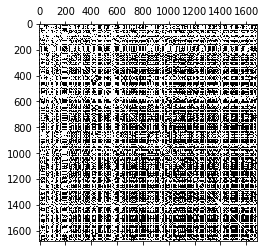

In [5]:
adjacency = epsilon_similarity_graph(genres.values, sigma=0.7, epsilon=0.1)
plt.spy(adjacency)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.show()

Build the combinatorial and normalized graph laplacians for this dataset.

In [6]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    diag_edge = adjacency.sum(axis=1)
    sqrt_D = np.power(diag_edge, -1/2)
    diag_edge = np.diag(diag_edge)
    laplacian = diag_edge - adjacency
    if normalize:
        laplacian = sqrt_D*laplacian*sqrt_D
    return laplacian

In [7]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

Then compute the eigendecomposition $L = U^\top \Lambda U$.

In [8]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, U = np.linalg.eigh(laplacian)

    return lamb, U

In [9]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

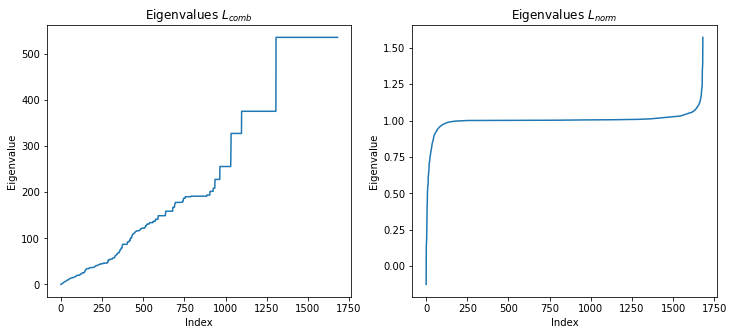

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

Since eigenvalues of normalized Laplacian has better numerical stability, we use it for further calculation.

In [11]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    n_components = sum(1 for i in lamb if i < threshold)
    return n_components

In [12]:
print(compute_number_connected_components(lamb_norm, threshold=1e-20))

1


Here we start to do dimension combined with clustering by K-means approach and visualize our results. For clusters, since we have 19 types of genres and normally one genre is associated with at least one other genre, 9 clusters could be a good choice. Then we set our cluster number to be 9.

**Note:** All of the graphs below are constructed directly by dimension reduction and clustering by K-means.

In [13]:
def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    adjacency = epsilon_similarity_graph(X, sigma, epsilon)
    laplacian = compute_laplacian(adjacency, normalize)
    lamb, U = spectral_decomposition(laplacian)
    # number of connected components = number of zero eigenvalues, 
    # zero eigenvalues are associated with constant vectors 
    n_CC = compute_number_connected_components(lamb, threshold=1e-12)
    # only take columns associated with non-zero eigenvalues
    cols_to_take = range(n_CC, n_CC + dim + 1)
    coords = U[:, cols_to_take]
    
    return coords

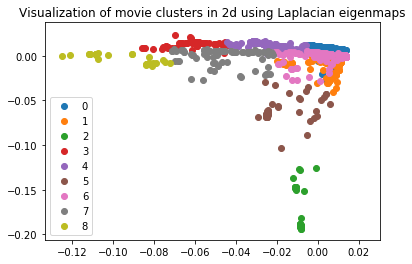

In [14]:
dim = 2
sigma = 1
epsilon = 0.3
normalize = True
classes = range(9)

X_2d = laplacian_eigenmaps(genres, dim, sigma, epsilon, normalize) #Embedding
km = KMeans(n_clusters = 9).fit(X_2d) #K-means for clustering
y_pred = km.labels_.astype(float)
for i in classes:
    mask = y_pred == i
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=i)
plt.legend()
plt.title("Visualization of movie clusters in 2d using Laplacian eigenmaps")
plt.show()

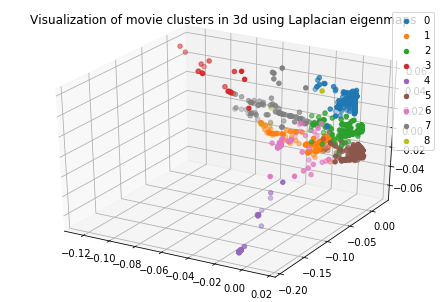

In [15]:
from mpl_toolkits.mplot3d import Axes3D

dim = 3
sigma = 1
epsilon = 0.3
normalize = True
classes = range(9)

X_3d = laplacian_eigenmaps(genres, dim, sigma, epsilon, normalize)
km = KMeans(n_clusters = 9).fit(X_3d)
y_pred = km.labels_.astype(float)

fig = plt.figure()
ax = Axes3D(fig)
for i in classes:
    mask = y_pred== i
    ax.scatter(X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2], label=i)
plt.legend()
plt.title("Visualization of movie clusters in 3d using Laplacian eigenmaps")
plt.show()

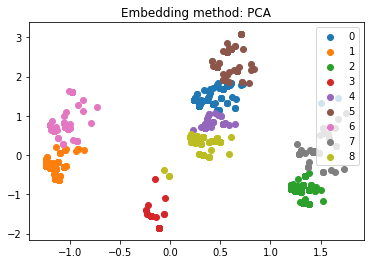

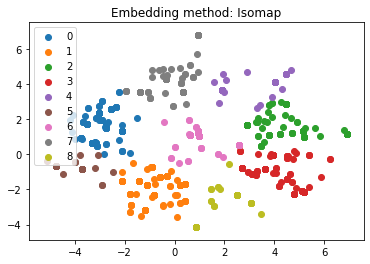

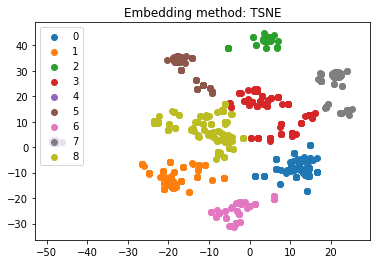

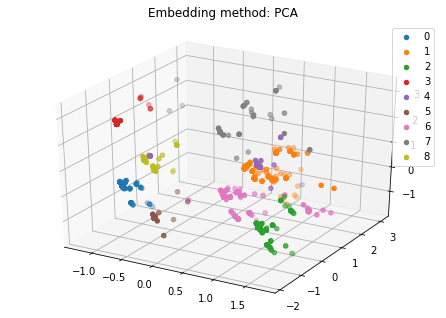

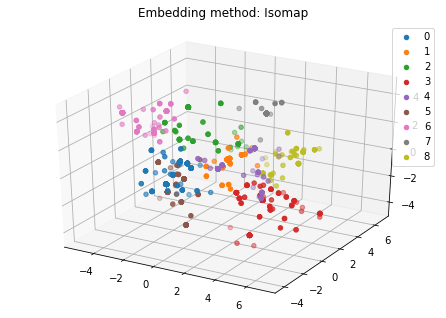

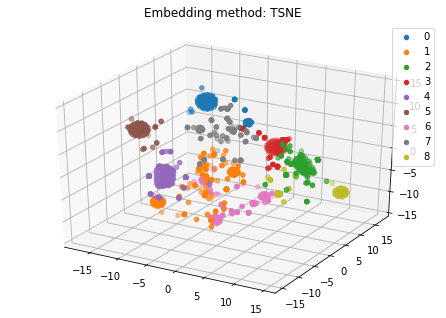

In [16]:
run_this_cell = True

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(genres)
        km = KMeans(n_clusters = 9).fit(X_embedded)
        y_pred = km.labels_.astype(float)
        fig = plt.figure()
        for i in classes:
            mask = y_pred == i
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(genres)
        km = KMeans(n_clusters = 9).fit(X_embedded)
        y_pred = km.labels_.astype(float)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_pred == i
            ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

Comparing the four dimension reduction methods(eigenmaps, PCA, Isomap and tSNE), we found tSNE seems to perform the best. The reason could be tSNE is a non-linear method which also circumvent crowding problem. 

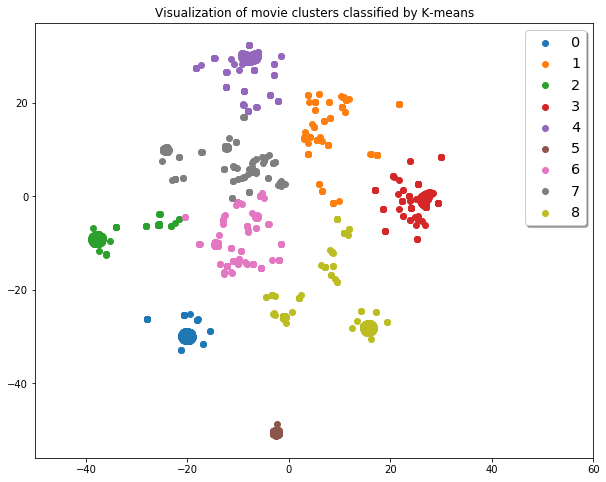

In [17]:
fig7=plt.figure(figsize=(10,8))
embedding = TSNE(n_components=2)
X_embedded = embedding.fit_transform(genres)
km = KMeans(n_clusters=9)
y_pred = km.fit(X_embedded).labels_.astype(int)

for i in classes:
    mask = y_pred == i
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)

plt.xlim(-50, 60)
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title("Visualization of movie clusters classified by K-means")
plt.show()
fig7.savefig('k_means.png', bbox_inches = 'tight')

Then we would like to know if the clusters make senses. Therefore, we count the genres in each cluster.

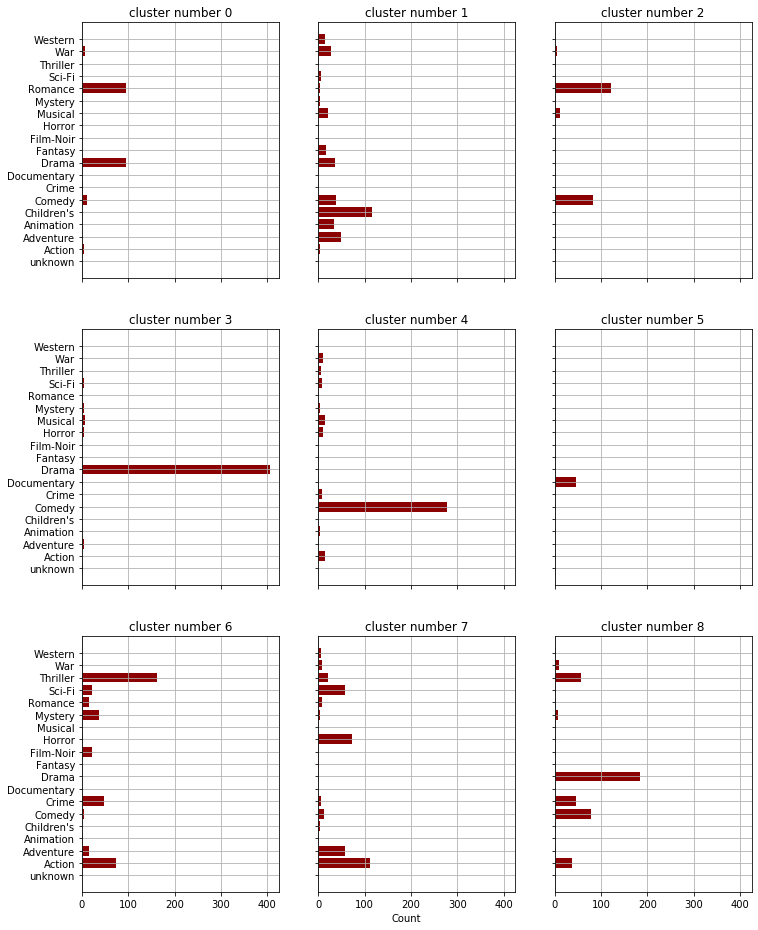

In [18]:
fig, ax = plt.subplots(3,3,figsize=(12,16), sharex=True, sharey=True)
fig.text(0.5,0.1,'Count', ha='center')
ax[0,0].title.set_text('cluster number 0')
ax[0,1].title.set_text('cluster number 1')
ax[0,2].title.set_text('cluster number 2')
ax[1,0].title.set_text('cluster number 3')
ax[1,1].title.set_text('cluster number 4')
ax[1,2].title.set_text('cluster number 5')
ax[2,0].title.set_text('cluster number 6')
ax[2,1].title.set_text('cluster number 7')
ax[2,2].title.set_text('cluster number 8')

for k in range(3):
    for j in range(3):
        if k==1:
            select = list( item.iloc[i,:]  for i in  np.where(y_pred == j+3))[0]
        elif k==2:
            select = list( item.iloc[i,:]  for i in  np.where(y_pred == j+6))[0]
        else:
            select = list( item.iloc[i,:]  for i in  np.where(y_pred == j))[0]

        ax[k,j%3].barh(select.columns[5:], width=np.sum(select.iloc[:,5:],axis =0), color="darkred")
        ax[k,j%3].grid()
        plt.rc('xtick', labelsize=10) 
        plt.rc('ytick', labelsize=10)
        plt.rc('axes', labelsize=10)
        if (j+1)%3==0:
            break;

fig.savefig('summary_kmeans.png', bbox_inches = 'tight')

From the results, we see cluster number 3, 4 and 5 have one prominent genre, which are drama, comedy and documentary, respectively. For cluster number 0 and 2, they have two obvious genres in each, which are ¨romance and drama¨ and ¨romance and comedy¨, respectively. Others clusters also have one significant genre in each, while they have more association with other genres, which is also reasonable, since one movie can have at most 6 genres in one movie in our dataset.